# scRNA(MALBAC) clustering

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import anndata
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns
from scipy.sparse import csr_matrix
from ALLCools.plot import *
from ALLCools.clustering import *
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/home/jzhou_salk_edu/sky_workdir/test_schicluster/Tan2021/'


In [3]:
data = pd.read_csv(f'{indir}other_data/GSE162509_UMIcount_mouse_decon_filtered_genes.tsv.gz', index_col=0, header=0, sep='\t')
data


,Gnai3,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,...,AC154500.1,AC114990.3,AC169675.1,AC109261.3,AC109261.4,AC154486.3,CAAA01189291.2,CT025659.3,AC136921.2,AC134446.1
PR10_HCA_P14HM-1_01,0,0,0,0,0,1,0,2,2,1,...,0,0,0,0,0,1,0,0,0,0
PR10_HCA_P14HM-1_02,0,0,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
PR10_HCA_P14HM-1_03,2,0,0,0,0,2,0,7,3,1,...,0,0,0,0,0,0,0,0,0,0
PR10_HCA_P14HM-1_04,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
PR10_HCA_P14HM-1_07,0,0,0,0,0,3,0,3,4,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PR10_HCA_P7PC-3_92,0,0,0,0,0,1,0,16,3,0,...,0,0,0,0,0,0,0,0,0,0
PR10_HCA_P7PC-3_93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PR10_HCA_P7PC-3_94,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
PR10_HCA_P7PC-3_95,0,0,0,0,0,0,0,8,1,3,...,0,0,0,0,0,0,0,0,0,0


In [4]:
meta = pd.read_csv(f'{indir}other_data/GSE162509_mapStat_mouse_filter.txt.gz', sep='\t', index_col=0, header=0)
meta

,Reads,Uniquely,Uniquely_ratio,Multi,Multi_ratio,Many,Many_ratio,A_ratio,Mapping_ratio,Genes,nUMI,mito,ERCC,assigned_ratio,avg.cor,keep
PR10_HCA_P14HM-1_01,3815377,3558074,0.9326,65771,0.0172,8865,0.0023,0.988705,0.9521,6414,36609,0.002103,0.020966,0.211559,0.418141,True
PR10_HCA_P14HM-1_02,936833,867607,0.9261,19886,0.0212,2618,0.0028,0.985054,0.9501,3184,7940,0.011083,0.074592,0.215140,0.352350,True
PR10_HCA_P14HM-1_03,2196459,2059892,0.9378,35331,0.0161,3744,0.0017,0.988487,0.9556,4710,16613,0.004093,0.028139,0.197201,0.393179,True
PR10_HCA_P14HM-1_04,1334069,1229429,0.9216,28281,0.0212,4119,0.0031,0.986058,0.9459,3825,10736,0.002701,0.056673,0.233741,0.364440,True
PR10_HCA_P14HM-1_05,268103,187902,0.7009,6316,0.0236,950,0.0035,0.968316,0.7280,1223,2617,0.049675,0.216936,0.355089,0.218429,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PR10_HCA_P7PC-3_92,1287766,1177633,0.9145,28821,0.0224,5017,0.0039,0.978918,0.9408,3593,11865,0.005057,0.056011,0.199417,0.356637,True
PR10_HCA_P7PC-3_93,676788,607913,0.8982,13266,0.0196,1459,0.0022,0.978000,0.9200,1945,4458,0.026918,0.108400,0.251697,0.294853,True
PR10_HCA_P7PC-3_94,2375796,2074957,0.8734,39335,0.0166,5894,0.0025,0.970208,0.8925,4040,18380,0.004570,0.050914,0.195646,0.369667,True
PR10_HCA_P7PC-3_95,1585829,1425909,0.8992,24091,0.0152,2937,0.0019,0.962138,0.9163,3752,16077,0.005411,0.059164,0.267316,0.368889,True


In [18]:
gene_meta = pd.read_csv('/data/ref/mm10/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz', header=0, index_col=None, sep='\t')
gene_meta

,chrom,source,feature,start,end,score,strand,phase,gene_id,transcript_id,...,gene_name,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
0,chr1,HAVANA,gene,3073253,3074322,.,+,.,ENSMUSG00000102693.1,NaN,...,4933401J01Rik,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
1,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,ENSMUSG00000064842.1,NaN,...,Gm26206,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
2,chr1,HAVANA,gene,3205901,3671498,.,-,.,ENSMUSG00000051951.5,NaN,...,Xkr4,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
3,chr1,HAVANA,gene,3252757,3253236,.,+,.,ENSMUSG00000102851.1,NaN,...,Gm18956,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
4,chr1,HAVANA,gene,3365731,3368549,.,-,.,ENSMUSG00000103377.1,NaN,...,Gm37180,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55482,chrM,ENSEMBL,gene,13552,14070,.,-,.,ENSMUSG00000064368.1,NaN,...,mt-Nd6,NaN,NaN,NaN,NaN,NaN,3,MGI:102495,NaN,NaN
55483,chrM,ENSEMBL,gene,14071,14139,.,-,.,ENSMUSG00000064369.1,NaN,...,mt-Te,NaN,NaN,NaN,NaN,NaN,3,MGI:102488,NaN,NaN
55484,chrM,ENSEMBL,gene,14145,15288,.,+,.,ENSMUSG00000064370.1,NaN,...,mt-Cytb,NaN,NaN,NaN,NaN,NaN,3,MGI:102501,NaN,NaN
55485,chrM,ENSEMBL,gene,15289,15355,.,+,.,ENSMUSG00000064371.1,NaN,...,mt-Tt,NaN,NaN,NaN,NaN,NaN,3,MGI:102473,NaN,NaN


In [22]:
gene_meta = gene_meta.loc[~gene_meta['gene_name'].duplicated()]
gene_meta = gene_meta.set_index('gene_name')[['chrom', 'start', 'end', 'gene_id', 'strand']]


In [28]:
data = data.loc[:, data.columns.isin(gene_meta.index)]

In [29]:
adata = anndata.AnnData(csr_matrix(data.values), 
                        obs=meta.loc[data.index, ['Genes', 'nUMI']],
                        var=gene_meta.loc[data.columns]
                      )
adata

AnnData object with n_obs × n_vars = 3517 × 39990
    obs: 'Genes', 'nUMI'
    var: 'chrom', 'start', 'end', 'gene_id', 'strand'

In [30]:
adata.write_h5ad('Tan2021_rna.h5ad')


In [3]:
adata = anndata.read_h5ad('Tan2021_rna.h5ad')
adata

AnnData object with n_obs × n_vars = 3517 × 3000
    obs: 'Genes', 'nUMI', 'umap_0', 'umap_1', 'age', 'region'
    var: 'chrom', 'start', 'end', 'gene_id', 'strand', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rna_pca_all'
    obsp: 'connectivities', 'distances'

In [4]:
cluster = pd.read_csv(f'{indir}metadata_major_cell_types.txt', sep='\t', header=None, index_col=0)[1]
cluster_neu = pd.read_csv(f'{indir}metadata_neuron_cell_types.txt', sep='\t', header=None, index_col=0)[1]
cluster.loc[cluster_neu.index] = cluster_neu.copy()
cluster.value_counts()

Hippocampal Granuale Cell                     398
Microglia Etc.                                364
Mature Oligodendrocyte                        314
Cortical L6 Pyramidal Cell                    297
Neonatal Astrocyte                            230
Oligodendrocyte Progenitor                    177
Hippocampal CA1 Pyramidal Cell                175
Cortical L2-5 Pyramidal Cell, Neonatal        156
Cortical L4 Pyramidal Cell                    151
Hippocampal Pyramidal Cell, Neonatal          136
Cortical L2/3 Pyramidal Cell                  134
Adult Astrocyte                               116
Cortical L5 Pyramidal Cell                     96
PV/SST Interneuron, Neonatal                   96
Unknown Interneuron 1                          94
VIP Interneuron                                85
Hippocampal CA3 Pyramidal Cell                 73
Medium Spiny Neuron                            73
Unknown Interneuron 2                          73
MEIS2 Interneuron                              53


In [18]:
adata.obs['region'] = [xx.split('-')[0].split('_')[-1][-2:] for xx in adata.obs.index]
adata.obs['age'] = [xx.split('-')[0].split('_')[-1][1:-2] for xx in adata.obs.index]
adata.obs['age'] = adata.obs['age'].astype(int)
adata.obs['cluster'] = cluster.copy()

In [4]:
sc.pp.filter_genes(adata, min_cells=10)


In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata.raw = adata.copy()
adata = adata[:, adata.var['highly_variable']].copy()
adata.X.data = adata.X.data / np.repeat(adata.obs['nUMI'].values, adata.X.getnnz(axis=1)) * adata.obs['nUMI'].median()
sc.pp.log1p(adata)


In [11]:
model = TruncatedSVD(n_components=50, algorithm='arpack', random_state=0) 
model.fit(adata.X)
sel_dim = (model.singular_values_ != 0)
print(sel_dim.sum())


50


In [30]:
data = model.transform(adata.X)
adata.obsm['rna_pca_all'] = data / model.singular_values_


In [28]:
significant_pc_test(adata, p_cutoff=0.1, update=False, obsm='rna_pca_all')


17 components passed P cutoff of 0.1.


17

In [10]:
adata.obsm['X_pca'] = normalize(adata.obsm['rna_pca_all'][:, :30], axis=1)


In [11]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata


In [12]:
knn = 25
sc.pp.neighbors(adata, n_neighbors=knn, use_rep='X_pca')
sc.tl.umap(adata, maxiter=200, random_state=0)
adata = dump_embedding(adata, 'umap')


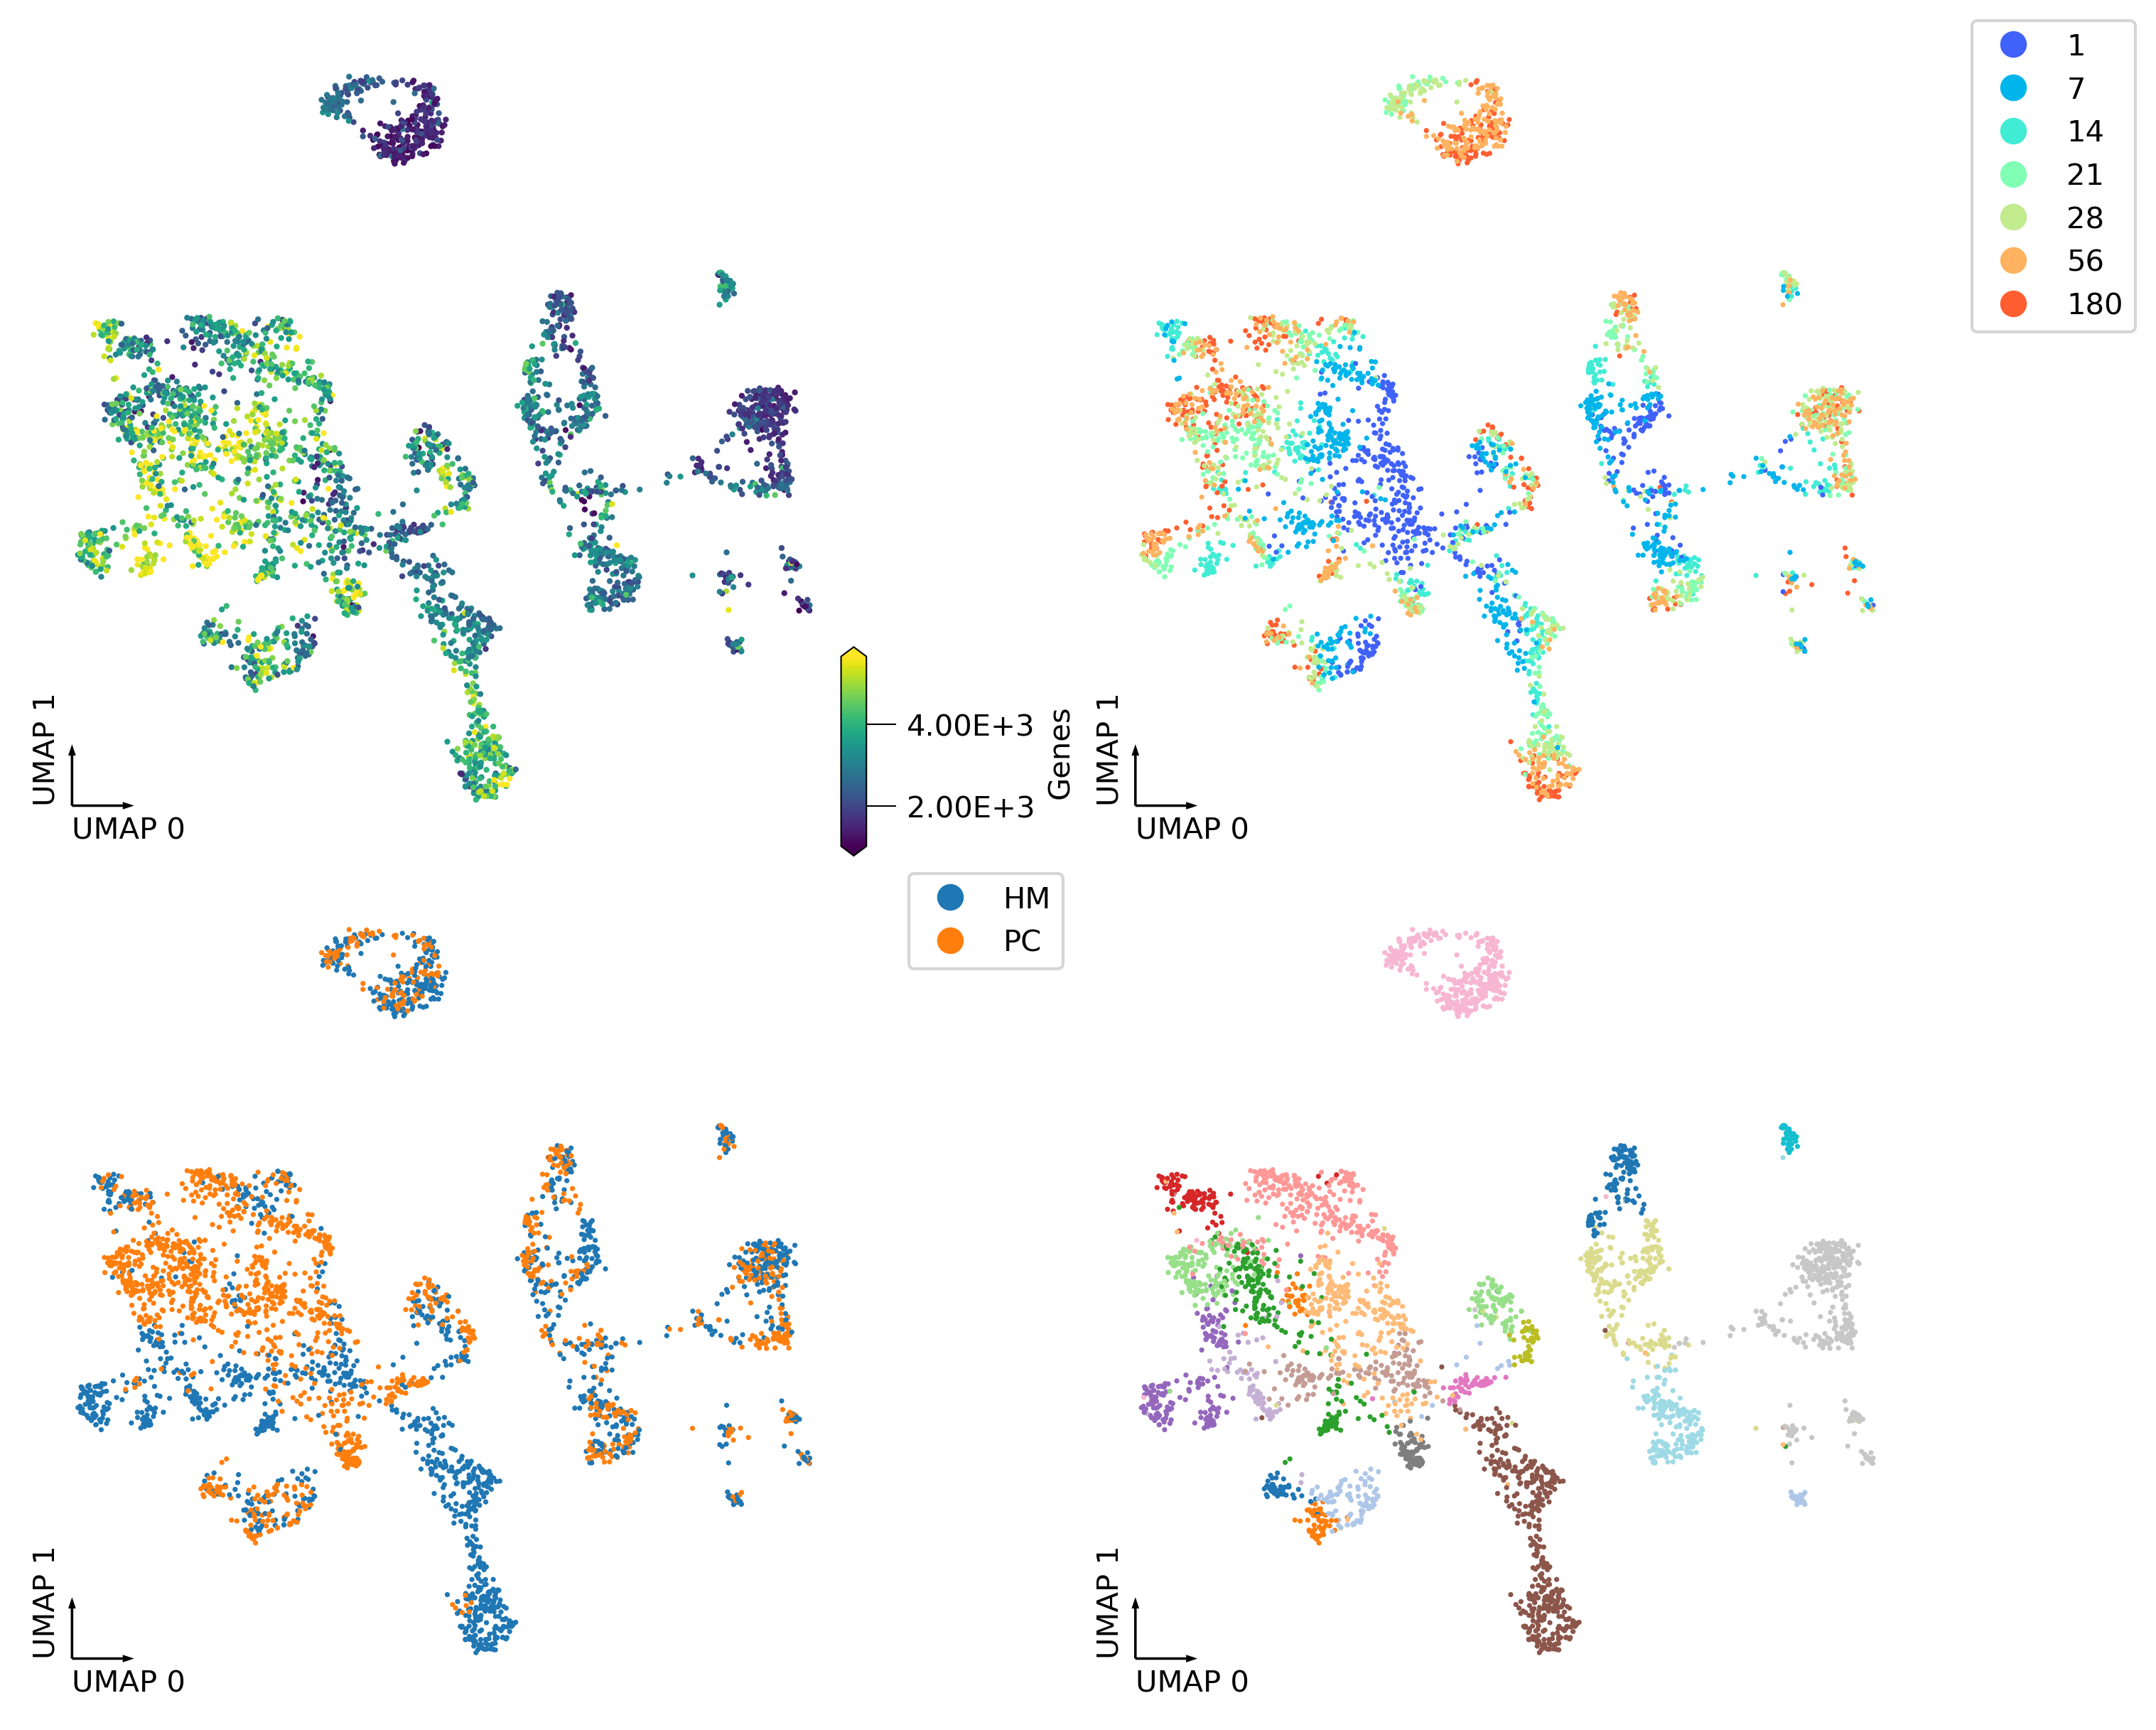

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, constrained_layout=True)
_ = continuous_scatter(ax=axes[0,0],
                       data=adata.obs,
                       hue='Genes',
                       coord_base='umap',
                       #max_points=None,
                       labelsize=10,
                       s=4)
_ = categorical_scatter(data=adata.obs,
                        ax=axes[0,1],
                        coord_base='umap',
                        hue='age',
                        palette='rainbow',
                        labelsize=10,
                        show_legend=True)
_ = categorical_scatter(ax=axes[1,0],
                        data=adata.obs,
                        hue='region',
                        coord_base='umap',
                        # text_anno='region',
                        # palette='tab10',
                        labelsize=10,
                        show_legend=True
                       )
_ = categorical_scatter(ax=axes[1,1],
                        data=adata.obs,
                        hue='cluster',
                        coord_base='umap',
                        # text_anno='cluster',
                        palette='tab20',
                        labelsize=10,
                        # show_legend=True
                       )



(0.0, 1.0, 0.0, 1.0)

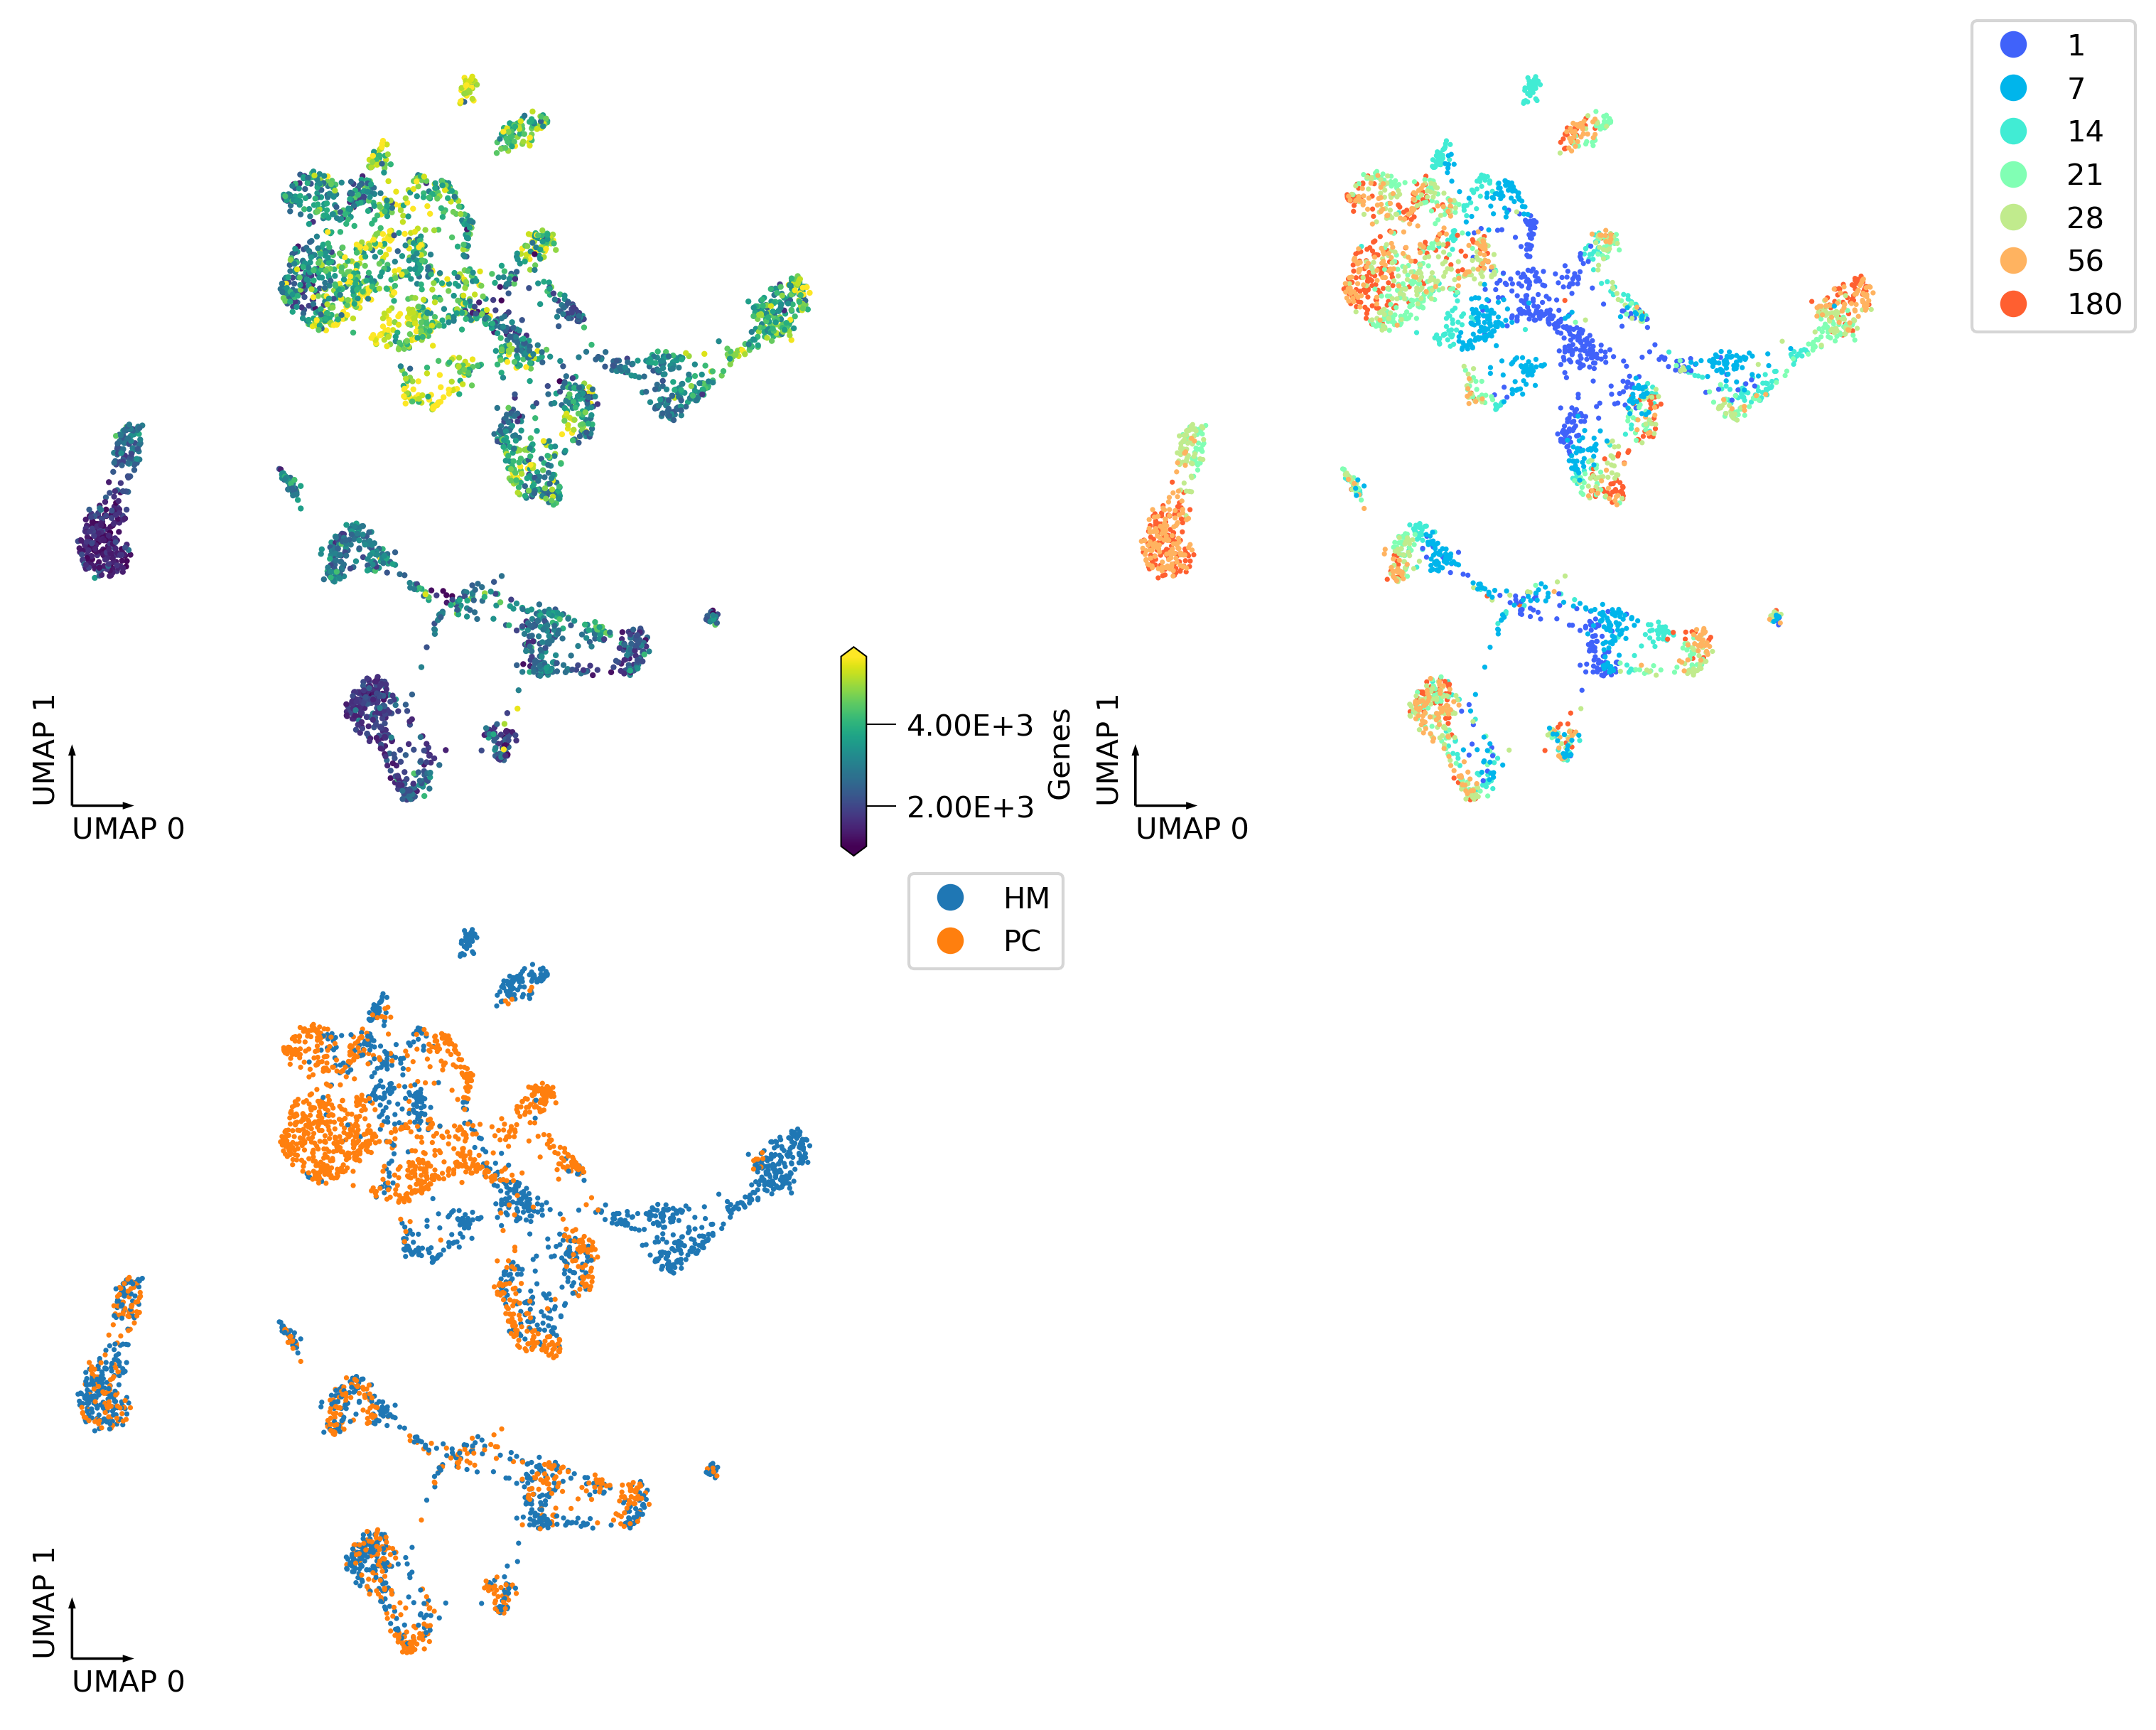

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, constrained_layout=True)
_ = continuous_scatter(ax=axes[0,0],
                       data=adata.obs,
                       hue='Genes',
                       coord_base='umap',
                       #max_points=None,
                       labelsize=10,
                       s=4)
_ = categorical_scatter(data=adata.obs,
                        ax=axes[0,1],
                        coord_base='umap',
                        hue='age',
                        palette='rainbow',
                        labelsize=10,
                        show_legend=True)
_ = categorical_scatter(ax=axes[1,0],
                        data=adata.obs,
                        hue='region',
                        coord_base='umap',
                        # text_anno='region',
                        # palette='tab10',
                        labelsize=10,
                        show_legend=True
                       )
_ = categorical_scatter(ax=axes[1,1],
                        data=adata.obs,
                        hue='cluster',
                        coord_base='umap',
                        # text_anno='cluster',
                        palette='tab20',
                        labelsize=10,
                        # show_legend=True
                       )


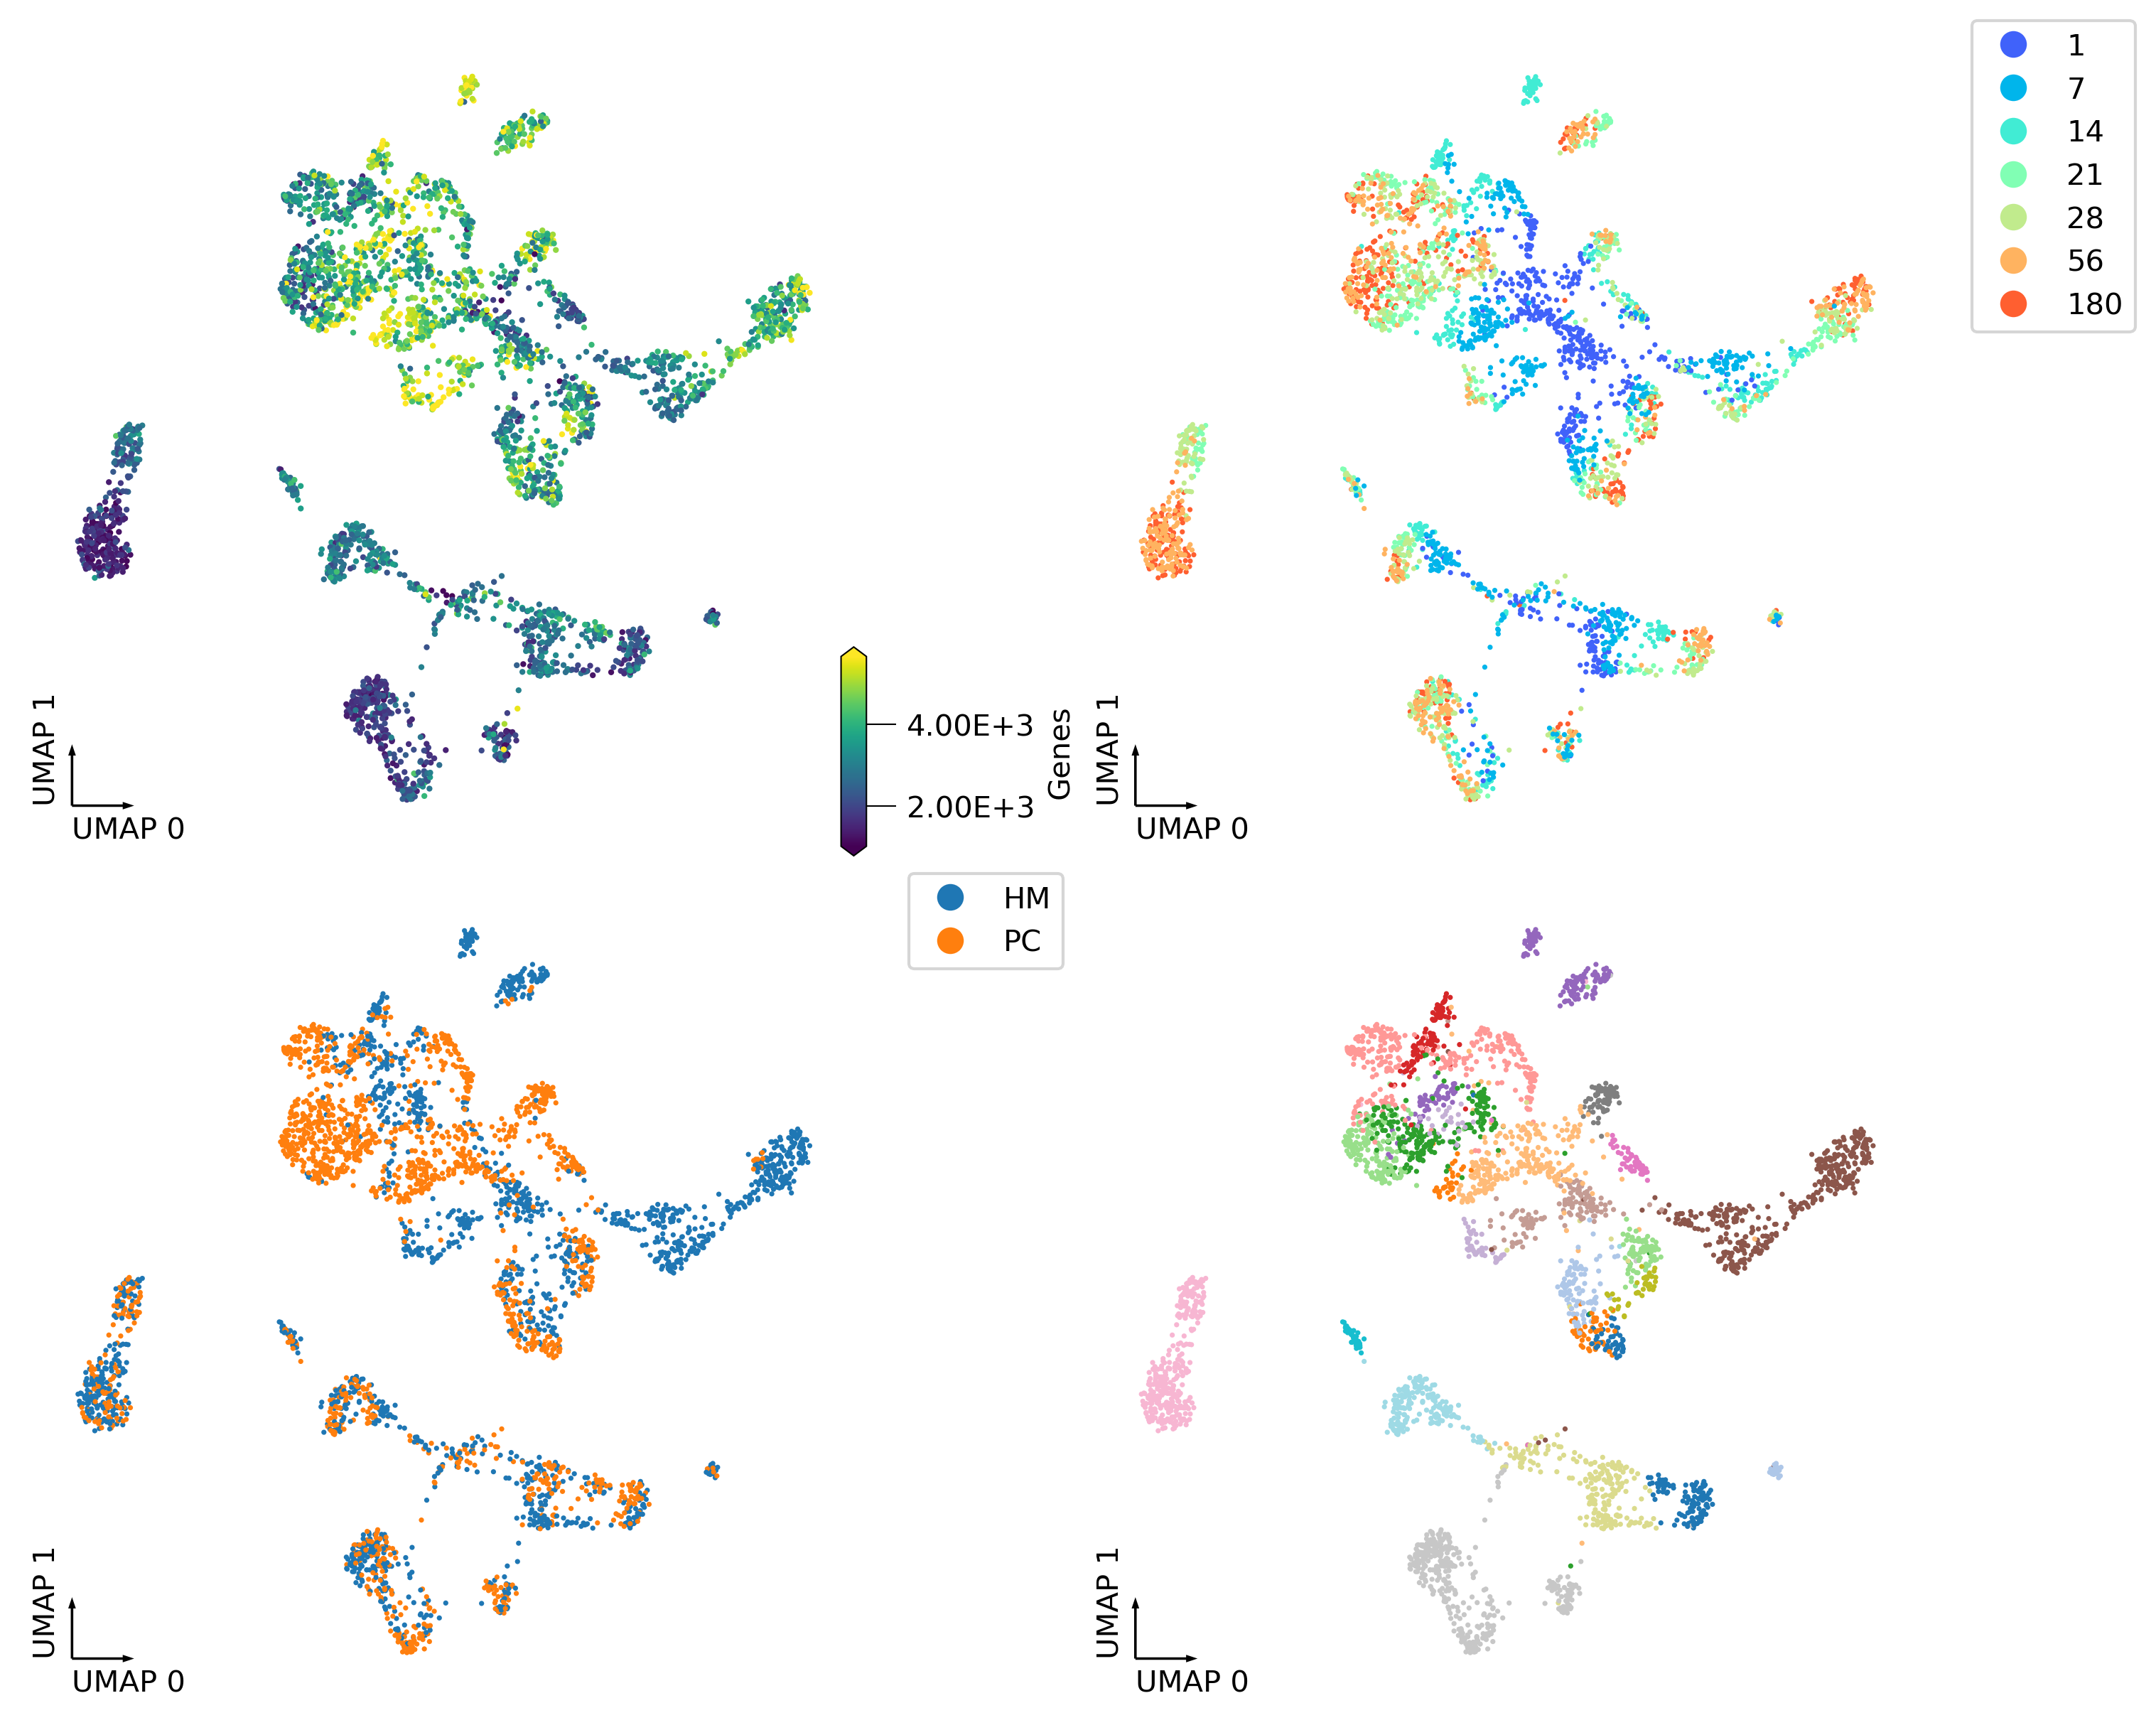

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, constrained_layout=True)
_ = continuous_scatter(ax=axes[0,0],
                       data=adata.obs,
                       hue='Genes',
                       coord_base='umap',
                       #max_points=None,
                       labelsize=10,
                       s=4)
_ = categorical_scatter(data=adata.obs,
                        ax=axes[0,1],
                        coord_base='umap',
                        hue='age',
                        palette='rainbow',
                        labelsize=10,
                        show_legend=True)
_ = categorical_scatter(ax=axes[1,0],
                        data=adata.obs,
                        hue='region',
                        coord_base='umap',
                        # text_anno='region',
                        # palette='tab10',
                        labelsize=10,
                        show_legend=True
                       )
_ = categorical_scatter(ax=axes[1,1],
                        data=adata.obs,
                        hue='cluster',
                        coord_base='umap',
                        # text_anno='cluster',
                        palette='tab20',
                        labelsize=10,
                        # show_legend=True
                       )


In [14]:
adata.write_h5ad('Tan2021_rna.h5ad')
